<a href="https://colab.research.google.com/github/GiocomoLab/tutorials/blob/main/signals_forwardbackward_filters_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#signal processing tutorial using python
## Date: 2021/12/2

Purpose: Quick tutorial to illustrate the use of python based tools to do basic signal processing on neural signals. In addition we will be looking at the specific application of simulating a hardware filter on a signal that as a consequence introduces a phase delay, and we will be trying to compensate for it by reverse filtering.


First lets do some import of libraries. We will be using primeraly the scipy signal processing toolbox, along with auxilary numerical libraries (numpy, pandas) and plotting libraries (matplotlib and seaborn). 

**Note that colab runs in python 3.7**. There are ways to use a newer version, but I haven't tried them. It is possible to upgrade certain packages withing colab, but package compalabilities issues might arise. 

In [ ]:
!python --version

Python 3.7.12


The code below shows you all the packages currently in your colab session. You can install additional packages with:   
`!pip install <package>`

In [ ]:
!pip list -v

In [ ]:
import scipy.signal as signal
from scipy.interpolate import interp1d
import scipy.stats as stats
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

## Signal Generation

In [ ]:
#@title Colored noise code { display-mode: "form" }
# colored noise code modified from: https://github.com/felixpatzelt/colorednoise/blob/master/colorednoise.py

def color_noise(beta, n_samples, fmin=0):
    """Gaussian (1/f)**beta noise.
    Based on the algorithm in: Timmer, J. and Koenig, M.: 
    On generating power law noise. Astron. Astrophys. 300, 707-710 (1995)
    Normalised to unit variance
    Parameters:
    -----------
    exponent : float
        The power-spectrum of the generated noise is proportional to
        S(f) = (1 / f)**beta
        flicker / pink noise:   exponent beta = 1
        brown noise:            exponent beta = 2
        Furthermore, the autocorrelation decays proportional to lag**-gamma
        with gamma = 1 - beta for 0 < beta < 1.
        There may be finite-size issues for beta close to one.
    n_samples : int 
        length of signal to be generated
    fmin : float, optional
        Low-frequency cutoff.
        Default: 0 corresponds to original paper. It is not actually
        zero, but 1/samples.
    Returns
    -------
    out : array
        The samples.
    Examples:
    ---------
    # generate 1/f noise == pink noise == flicker noise
    >>> import colorednoise as cn
    >>> y = color_noise(1, 5)
    """
    
    # Calculate Frequencies (we asume a sample rate of one)
    # Use fft functions for real output (-> hermitian spectrum)
    f = np.fft.rfftfreq(n_samples)
    
    # Build scaling factors for all frequencies
    s_scale = f
    fmin = max(fmin, 1./n_samples) # Low frequency cutoff
    
    ix   = np.sum(s_scale < fmin)   # Index of the cutoff
    if ix and ix < len(s_scale):
        s_scale[:ix] = s_scale[ix]
    
    s_scale = s_scale**(-beta/2.)
    
    # Calculate theoretical output standard deviation from scaling
    w      = s_scale[1:].copy()
    w[-1] *= (1 + (n_samples % 2)) / 2. # correct f = +-0.5
    sigma = 2 * np.sqrt(np.sum(w**2)) / n_samples

    # Generate scaled random power + phase
    sr = np.random.normal(scale=s_scale)
    si = np.random.normal(scale=s_scale)
    
    # If the signal length is even, frequencies +/- 0.5 are equal
    # so the coefficient must be real.
    if not (n_samples % 2): si[...,-1] = 0
    
    # Regardless of signal length, the DC component must be real
    si[...,0] = 0
    
    # Combine power + corrected phase to Fourier components
    s  = sr + 1J * si
    
    # Transform to real time series & scale to unit variance
    y = np.fft.irfft(s, n=n_samples, axis=-1) / sigma
    
    return y

First, lets create a signal. In our case we will simulate a local field potential signal with a wide spectrum and a $\frac{1}{f}$ power decay (pink noise). We willbe using the `color_noise` function defined above.

In [ ]:
signal_length_s = 60*5  # 5 minute signal
sim_samp_rate = 90000  # we are simulating an analog signal, so lets have a super high sampling rate
pink_noise_scale = 1
white_noise_scale = 0.5
sim_n_samps = signal_length_s*sim_samp_rate  # total number of samples in the simulated signal

sim_time = np.arange(0,signal_length_s, 1/sim_samp_rate)

sim_pink_noise = color_noise(1,sim_n_samps)*pink_noise_scale
sim_white_noise = np.random.normal(size=sim_n_samps)*white_noise_scale
sim_noise = sim_pink_noise + sim_white_noise

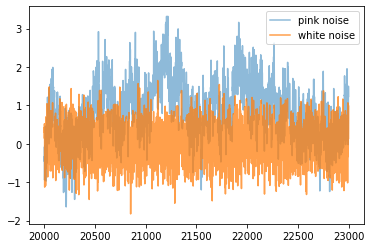

In [ ]:
#@title Visualize the noise signal { run: "auto", vertical-output: true, display-mode: "form" }
plot_ix = 20000 #@param {type:"integer"}
window_length =  3000#@param {type:"integer"}
win = np.arange(plot_ix, (plot_ix+window_length))
plt.plot(win, sim_pink_noise[win], alpha=0.5, label='pink noise')
plt.plot(win, sim_white_noise[win], alpha=0.75, label = 'white noise')
plt.legend(loc='best')
plt.show()

### Visualize the noise spectrum

We will cover the fourier transform (FT) more in depth in a bit, but for now the code below plots the PSD (power spectrum density), a method of visuzalizing the frequency content of a **stochastic** signal. This means averaging (different than just taking the FT). 

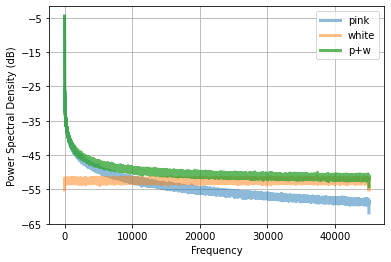

In [ ]:
 NFFT = 2**np.ceil(np.log2(sim_samp_rate)).astype(int)
_=plt.psd(sim_pink_noise, Fs=sim_samp_rate, scale_by_freq=False, NFFT=NFFT, lw=3, alpha=0.5, label='pink')
_=plt.psd(sim_white_noise, Fs=sim_samp_rate, scale_by_freq=False, NFFT=NFFT, lw=3, alpha=0.5, label='white')
_=plt.psd(sim_noise, Fs=sim_samp_rate, scale_by_freq=False, NFFT=NFFT, lw=3, alpha=0.75, label='p+w')
plt.legend(loc='best')

### Generating a sinusoidal signal with stochastic frequency

We can take several approaches to accomplish this, but here we will create a gaussian around the target frequency and then use the inverse FT to obtain the signal.


In [ ]:
def generate_lfp_freq(freq,n_samps,sigma_scale=1):

  freqs = np.fft.rfftfreq(n_samps)
  
  sigma = sigma_scale/n_samps

  amps = gaussian(freqs,freq/(n_samps), sigma)
  
  w      = amps[1:].copy()
  w[-1] *= (1 + (n_samps % 2)) / 2. # correct f = +-0.5
  
  freq_scale = 2 * np.sqrt(np.sum(w**2)) / n_samps
  
  # Generate scaled random power + phase
  sr = np.random.normal(scale=amps)
  si = np.random.normal(scale=amps)
  
  # If the signal length is even, frequencies +/- 0.5 are equal
  # so the coefficient must be real.
  if not (n_samps % 2): si[...,-1] = 0
  
  # Regardless of signal length, the DC component must be real
  si[...,0] = 0
  sr[...,0] = 0
  
  # Combine power + corrected phase to Fourier components
  s  = sr + 1J * si

  # Transform to real time series & scale to unit variance
  y = np.fft.irfft(s, n=n_samps, axis=-1) / freq_scale

  return y

def gaussian(x, mu, sigma):
  return 1/(sigma*np.sqrt(2*np.pi)) * np.exp( -0.5 * (x-mu)**2/sigma**2)

def plot_spectrum(freqs,amp,range=None, scale='dB', plot_phase=False, logscale=False, axes=None):

  if axes is None:
    if plot_phase:
      fig,ax=plt.subplots(2,1)
      axes = ax
    else:
      fig,ax=plt.subplots(1,1)
      axes = [ax,ax]
  else:
    assert len(axes)==2

  if range is not None:
    ix = (freqs<range[1]) & (freqs>=range[0])
    freqs = freqs[ix]
    amp = amp[ix]

  if scale == 'dB':
    if logscale:
      axes[0].semilogx(freqs,20*np.log10(amp), lw=3)
    else:
      axes[0].plot(freqs,20*np.log10(amp), lw=3)
    axes[0].set_ylabel('Amplitude dB')
  else:
    axes[0].plot(freqs, amp, lw=3)
    axes[0].set_ylabel('Amp')
  
  axes[0].set_xlabel('Freq (Hz)')

  if plot_phase:
    ang = np.unwrap(np.angle(amp))
    if logscale:
      axes[1].semilogx(freqs,ang, lw=3)
    else:
      axes[1].plot(freqs,ang, lw=3)
    axes[1].set_ylabel('Angle (rad)')

  return axes

In [ ]:
target_freq = 7
freq_spread = 3
sim_theta_signal = generate_lfp_freq(target_freq*signal_length_s, sim_n_samps, freq_spread*100)

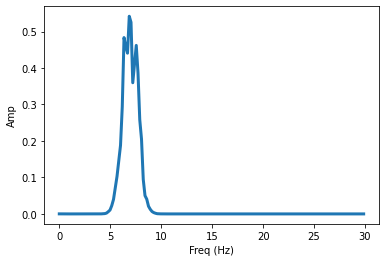

In [ ]:
f,a = signal.welch(sim_theta_signal,fs=sim_samp_rate,nperseg=2**19, noverlap=0)
plot_spectrum(f,a, range=[0,30], scale='Amp')

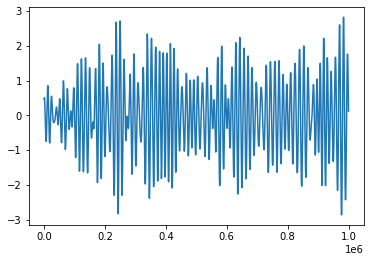

In [ ]:
plt.plot(sim_theta_signal[:1000000])

In [ ]:
target_freqs = [2,3,4,5,6]
freq_spread = 2
sim_theta_signal = np.zeros_like(sim_noise)
for target_freq in target_freqs:
  sim_theta_signal += generate_lfp_freq(target_freq*signal_length_s, sim_n_samps, freq_spread*100)

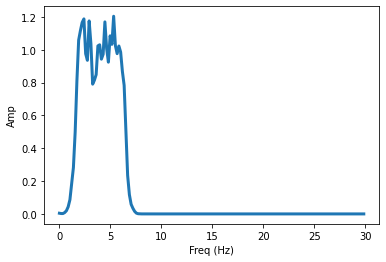

In [ ]:
f,a = signal.welch(sim_theta_signal,fs=sim_samp_rate,nperseg=2**19, noverlap=0)
plot_spectrum(f,a, range=[0,30], scale='Amp')

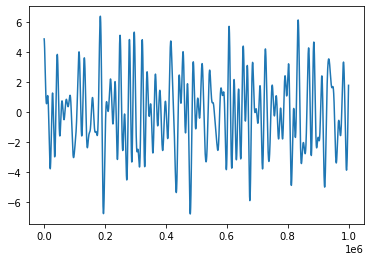

In [ ]:
plt.plot(sim_theta_signal[:1000000])

### Generating phased-locked spikes

For a given phase, lets add spikes.

#### spike wf creation

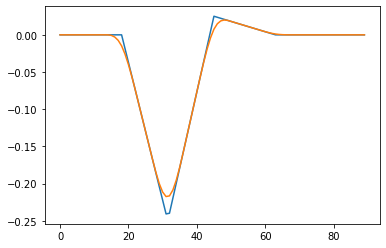

In [ ]:
spike_wf_amp = [0,0,-0.25,0.025,0, 0] # amplitudes
spike_wf_time = np.array([0,0.2,0.35,0.5,0.7,1])/1000 # time in ms of each amp point
spike_interp_func = interp1d(spike_wf_time,spike_wf_amp, kind='linear')

spike_wf_raw = spike_interp_func(np.arange(0,0.001,1/sim_samp_rate))
spike_wf = signal.filtfilt(np.ones(5)/5,1,spike_wf_raw)

plt.plot(spike_wf_raw)
plt.plot(spike_wf)

#### phase matching
 lets find phases in the theta signal that match a target phase

In [ ]:
sim_phase = np.pi/2
sim_prob_spike = 0.1

In [ ]:
sim_theta_an_signal = signal.hilbert(sim_theta_signal)
sim_theta_amp = abs(sim_theta_an_signal)
sim_theta_angle = np.angle(sim_theta_an_signal)

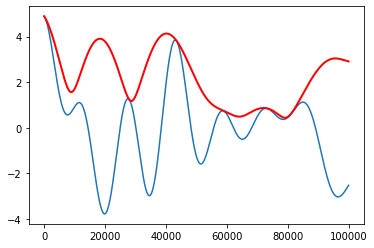

In [ ]:
win = np.arange(100000)
plt.plot(sim_theta_signal[win])
plt.plot(sim_theta_amp[win],'r', lw=2)

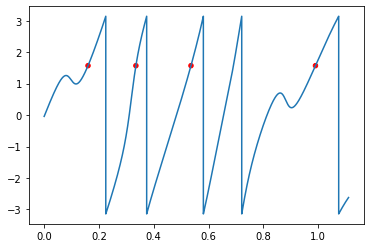

In [ ]:
sim_phase_match = np.isclose(sim_theta_angle, sim_phase, rtol=0.0001)

plt.plot(sim_time[win], sim_theta_angle[win])
plt.scatter(sim_time[win],sim_theta_angle[win]*sim_phase_match[win], 
            s=sim_phase_match[win]*20, color='r')

#### insertion of spikes into theta signal

In [ ]:
sim_spk_locs = sim_phase_match*(np.random.rand(sim_n_samps)<sim_prob_spike)
sim_spike_wfs = signal.lfilter(spike_wf/abs(spike_wf.sum()),1, sim_spk_locs.astype(np.double))

(14000.0, 15000.0)

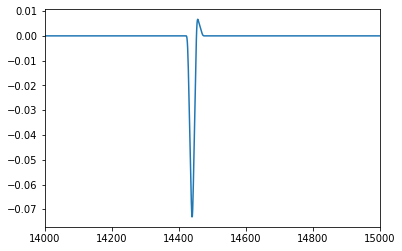

In [ ]:
plt.plot(sim_spike_wfs[win])
plt.xlim([14000,15000])

### adding it all

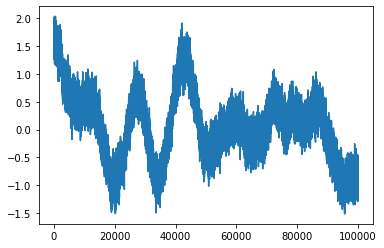

In [ ]:
sim_signal = sim_noise*0.2 + sim_theta_signal*0.3 + sim_spike_wfs
plt.plot(sim_signal[win])

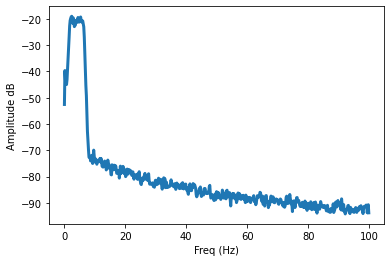

In [ ]:
f,a = signal.welch(sim_signal,fs=sim_samp_rate,nperseg=2**19, noverlap=0)
plot_spectrum(f,a, range=[0,100], scale='dB')

## NPX recording
Now lets simulate what happens with a NPX acquisition. The are 2 signals, AP and LP by their nomenclature, acquired at different rates with different gains. 
During acquisition, these bands are filtered with RC hardware filters of order 1. We will attempt to simulate the effect of these filters, and subsequently compensate for their group delay.

1. Filter data into the 2 bands of interest.
2. Downsample (decimate) to match NPX acquisition parameters.

[npx reference tech paper](https://https://ieeexplore-ieee-org.stanford.idm.oclc.org/stamp/stamp.jsp?tp=&arnumber=7900417)

In [ ]:
# these are the defaul NPX 1.0 recording parameters
ap_samp_rate = 30000
lfp_samp_rate = 2500

lfp_band = [0.5,1000]
ap_band = [300, 10000]

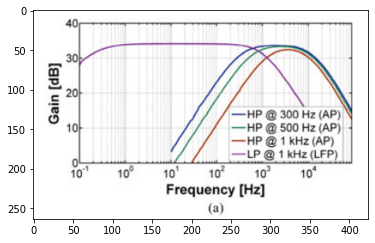

In [ ]:
try:
  img = plt.imread(Path("/content/drive/MyDrive/Colab Notebooks/npx_freq_resp.PNG"))
  plt.imshow(img)
except:
  pass

In [ ]:
def plot_filter(b,a, ftype='digital'):

  if ftype=='digital':
    w,h = signal.freqz(b,a)
  else:
    w, h = signal.freqs(b, a)
    
  ax = plot_spectrum(w,h,plot_phase=True, logscale=True)
  ax[0].set_xlim([0.1,10e4])
  ax[0].grid()
  ax[1].set_xlim([0.1,10e4])
  ax[1].grid()

#### Filtering 
Equivalent filters to the ones used in the paper. Note, these cannot be used to filter the data, it simply to see if we can match the ideal response.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


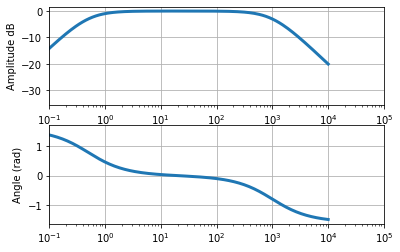

In [ ]:
lfp_filter_band_pass_an = signal.butter(1,Wn=lfp_band,btype='band',analog=True)
plot_filter(lfp_filter_band_pass_an[0],lfp_filter_band_pass_an[1],ftype='analog')

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


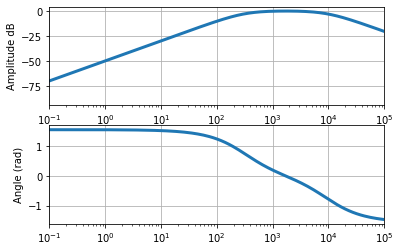

In [ ]:
ap_filter_band_pass_an = signal.butter(1,Wn=ap_band,btype='band',analog=True)
plot_filter(ap_filter_band_pass_an[0],ap_filter_band_pass_an[1],ftype='analog')
#plt.ylim([-40, 0])

Now let's try to create digital equivalents

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fcc42bba4d0>,
      dtype=object)

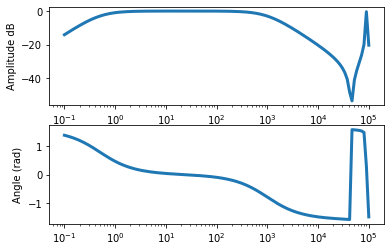

In [ ]:
lfp_filter_band_pass_di=signal.butter(1,Wn=lfp_band,btype='band', analog=False, fs=sim_samp_rate)
#lfp_filter_band_pass_di = signal.bilinear(*lfp_filter_band_pass_an,fs=sim_samp_rate)
f,h=signal.freqz(*lfp_filter_band_pass_di, fs=sim_samp_rate, worN=np.logspace(-1,5,2**7))
plot_spectrum(f,h,plot_phase=True,logscale=True)

Comparing the LFP filter responses:

In [ ]:
f_lfp_di, H_lfp_di = signal.freqz(*lfp_filter_band_pass_di, fs=sim_samp_rate, worN=np.logspace(-1,5,2**7))
f_lfp_an, H_lfp_an = signal.freqs(*lfp_filter_band_pass_an, worN=f_lfp_di)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(-40.0, 5.0)

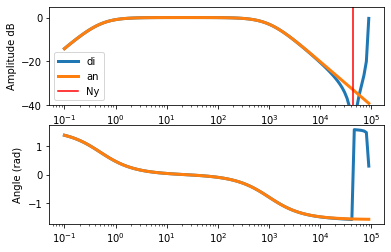

In [ ]:
ax = plot_spectrum(f_lfp_di,H_lfp_di,plot_phase=True,logscale=True, range=[0.1,100000])  
ax = plot_spectrum(f_lfp_an,H_lfp_an,plot_phase=True,logscale=True, range=[0.1,100000],axes=ax)  
ax[0].axvline(sim_samp_rate/2,color='r')
ax[0].legend(['di','an','Ny'])
ax[0].set_ylim([-40,5])

In [ ]:
ap_filter_band_pass_di=signal.butter(1,Wn=ap_band,btype='band', analog=False, fs=sim_samp_rate)
f_ap_di, H_ap_di = signal.freqz(*ap_filter_band_pass_di, fs=sim_samp_rate, worN=np.logspace(-1,5,2**7))
f_ap_an, H_ap_an = signal.freqs(*ap_filter_band_pass_an, worN=f_lfp_di)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(-40.0, 5.0)

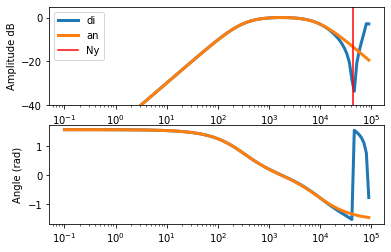

In [ ]:
ax = plot_spectrum(f_ap_di,H_ap_di,plot_phase=True,logscale=True, range=[0.1,100000])  
ax = plot_spectrum(f_ap_an,H_ap_an,plot_phase=True,logscale=True, range=[0.1,100000],axes=ax)  
ax[0].axvline(sim_samp_rate/2,color='r')
ax[0].legend(['di','an','Ny'])
ax[0].set_ylim([-40,5])

In both instances of filters we were able to match the frequency response of the analog signal, with possible deviations nearing the Nyquist rate, which is expected.

### Group Delay
When dealing with IIR or analog filters, each frequency can have a different amount of delay in the output. Let's examine the effects of the bandpass filters we designed.

In [ ]:
ap_filter_grpd = signal.group_delay(ap_filter_band_pass_di,w=f_ap_di,fs=sim_samp_rate)
lfp_filter_grpd = signal.group_delay(lfp_filter_band_pass_di,w=f_lfp_di,fs=sim_samp_rate)

Text(0, 0.5, 'Delay (s)')

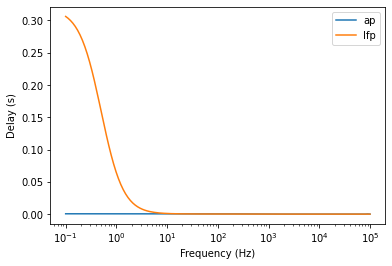

In [ ]:
f,ax = plt.subplots()
ax.semilogx(f_ap_di, ap_filter_grpd[1]/sim_samp_rate, label='ap')
ax.semilogx(f_lfp_di, lfp_filter_grpd[1]/sim_samp_rate, label='lfp')
ax.legend(loc='best')
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Delay (s)")

In [ ]:
lfp_delay_table = pd.DataFrame(index=np.arange(12),columns=['freq', 'delay_ms', 'delay_rad'])
for freq in np.arange(12):
  delay_s = lfp_filter_grpd[1][np.argmin(abs(f_lfp_di-freq))]/sim_samp_rate
  delay_ph = delay_s*freq/(2*np.pi)
  lfp_delay_table.loc[freq] = freq, delay_s*1000, delay_ph
lfp_delay_table

,freq,delay_ms,delay_rad
0,0,305.945,0
1,1,65.7267,0.0104607
2,2,17.2054,0.00547666
3,3,9.26821,0.00442524
4,4,4.96774,0.00316256
5,5,3.28789,0.00261642
6,6,2.19108,0.00209233
7,7,1.79585,0.00200073
8,8,1.47717,0.0018808
9,9,1.22034,0.00174801


In [ ]:
ap_delay_table = pd.DataFrame(index=np.arange(12),columns=['freq', 'delay_ms', 'delay_rad'])
for freq in np.arange(12):
  delay_s = ap_filter_grpd[1][np.argmin(abs(f_ap_di-freq))]/sim_samp_rate
  delay_ph = delay_s*freq/(2*np.pi)
  ap_delay_table.loc[freq] = freq, delay_s*1000, delay_ph
ap_delay_table

,freq,delay_ms,delay_rad
0,0,0.515235,0
1,1,0.515229,8.20012e-05
2,2,0.515212,0.000163997
3,3,0.515192,0.000245986
4,4,0.515153,0.000327957
5,5,0.51511,0.000409911
6,6,0.515042,0.000491829
7,7,0.514996,0.000573749
8,8,0.514938,0.00065564
9,9,0.514867,0.000737492


Note the problematic delay for low frequencies in the lpf band.

## Filtering and downsampling
In this step we take the synthetic signal, filter it and downsample to match the NPX recording.

In [ ]:
ap_signal = signal.lfilter(*ap_filter_band_pass_di,sim_signal)
ap_q = sim_samp_rate//ap_samp_rate
ap_signal = ap_signal[::ap_q]
ap_time = sim_time[::ap_q]

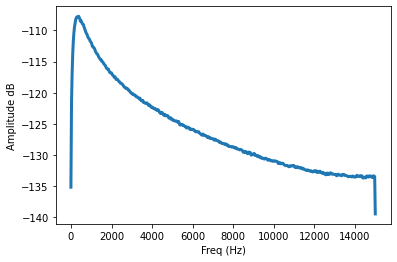

In [ ]:
f,a = signal.welch(ap_signal,fs=ap_samp_rate,nperseg=2**10, noverlap=0)
plot_spectrum(f,a, scale='dB')

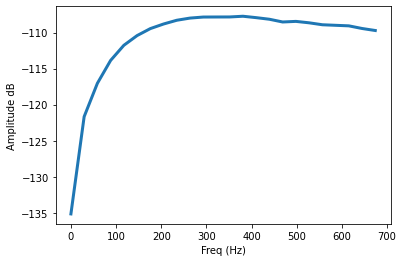

In [ ]:
plot_spectrum(f,a, scale='dB', range=[0,700])

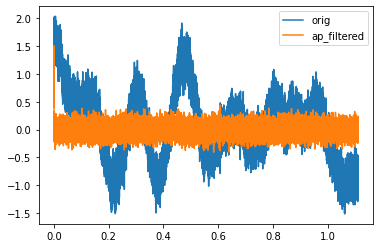

In [ ]:
plt.plot(sim_time[win], sim_signal[win], label='orig')
ap_win = win[:(len(win)//ap_q)]
plt.plot(ap_time[ap_win], ap_signal[ap_win],label='ap_filtered')
plt.legend(loc='best')

In [ ]:
lfp_signal = signal.lfilter(*lfp_filter_band_pass_di,sim_signal)
lfp_q = sim_samp_rate//lfp_samp_rate
lfp_signal = lfp_signal[::lfp_q]
lfp_time = sim_time[::lfp_q]

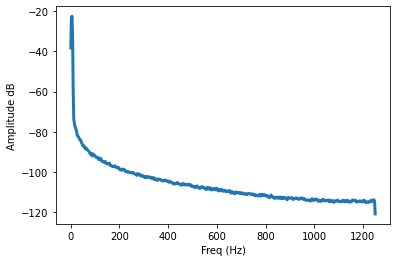

In [ ]:
f,a = signal.welch(lfp_signal,fs=lfp_samp_rate,nperseg=2**10, noverlap=0)
plot_spectrum(f,a, scale='dB')

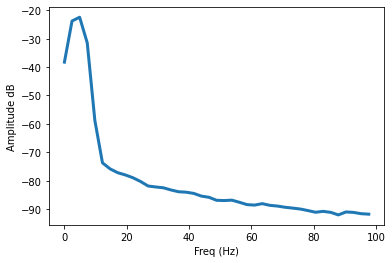

In [ ]:
plot_spectrum(f,a, scale='dB', range=[0,100])

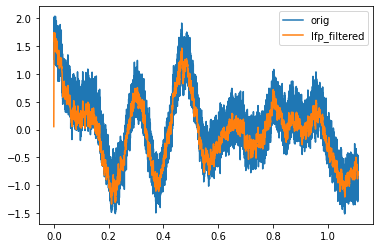

In [ ]:
plt.plot(sim_time[win], sim_signal[win], label='orig')
lfp_win = win[:(len(win)//lfp_q)]
plt.plot(lfp_time[lfp_win], lfp_signal[lfp_win],label='lfp_filtered')
plt.legend(loc='best')

## Finding the phase of our spikes

In [ ]:
lfp_spk_locs = np.where(sim_spk_locs)[0]//lfp_q

In [ ]:
lfp_analytic = signal.hilbert(lfp_signal)
lfp_amp = abs(lfp_analytic)
lfp_phase = np.angle(lfp_analytic)

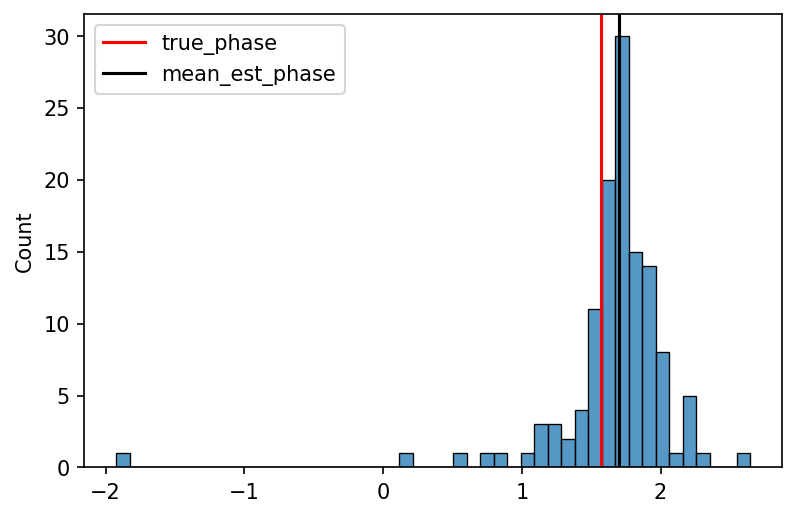

In [ ]:
lfp_spk_phases = lfp_phase[lfp_spk_locs]
m_lfp_spk_phase = stats.circmean(lfp_spk_phases)
f,ax=plt.subplots(dpi=150)
ax = sns.histplot(lfp_spk_phases,ax=ax)
ax.axvline(sim_phase, color='r',label='true_phase')
ax.axvline(m_lfp_spk_phase, color='k',label='mean_est_phase')
ax.legend(loc='best')

In [ ]:
phase_error_rad = m_lfp_spk_phase-sim_phase
phase_error_deg = np.rad2deg(phase_error_rad)
print(f"The filter introduced a mean error of {phase_error_deg:0.2f} degrees.")

The filter introduced a mean error of 7.44 degrees.


## correcting for phase delay
We have found that the lfp filter introduces a delay that affects the estimation of the phase. We will compensate for it by filtering with an equivalent lfp filter, and applying it on the reversed signal.

In [ ]:
lfp_filter_band_pass_di_2 =signal.butter(1,Wn=lfp_band,btype='band', analog=False, fs=lfp_samp_rate)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


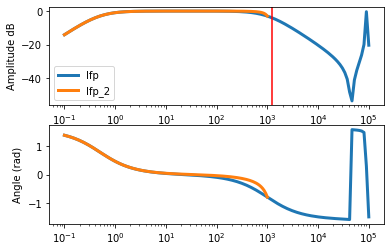

In [ ]:
axes = plot_spectrum(f_lfp_di,H_lfp_di,plot_phase=True,logscale=True)
f_lfp_2,H_lfp_2=signal.freqz(*lfp_filter_band_pass_di_2, fs=lfp_samp_rate, worN=np.logspace(-1,3,2**7))
axes = plot_spectrum(f_lfp_2,H_lfp_2,plot_phase=True,logscale=True, axes=axes)
axes[0].legend(['lfp', 'lfp_2'])
axes[0].axvline(lfp_samp_rate/2,color='r',label='Ny_lfp_2')

Text(0, 0.5, 'Delay (s)')

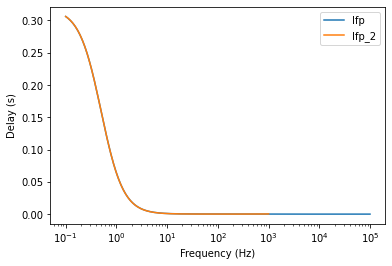

In [ ]:
lfp_filter_grpd_2 = signal.group_delay(lfp_filter_band_pass_di_2,w=f_lfp_2,fs=lfp_samp_rate)
f,ax = plt.subplots()
ax.semilogx(f_lfp_di, lfp_filter_grpd[1]/sim_samp_rate, label='lfp')
ax.semilogx(f_lfp_2, lfp_filter_grpd_2[1]/lfp_samp_rate, label='lfp_2')
ax.legend(loc='best')
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Delay (s)")

Although there are some differences at frequencies near the LFP Nyquist rate, at low frequencies the filters are well matched, which will serve our purposes.

In [ ]:
lfp_signal_r = lfp_signal[::-1].copy()
lfp_signal_2 = signal.lfilter(*lfp_filter_band_pass_di_2, lfp_signal_r)
lfp_signal_2 = lfp_signal_2[::-1]

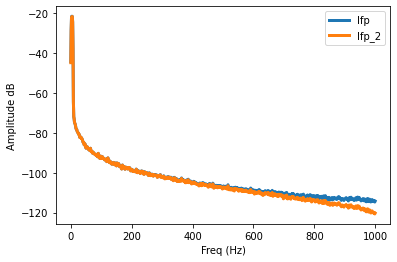

In [ ]:
f,a = signal.welch(lfp_signal,fs=lfp_samp_rate,nperseg=2**11, noverlap=0)
axes = plot_spectrum(f,a, scale='dB', range=[0,1000])

f,a = signal.welch(lfp_signal_2,fs=lfp_samp_rate,nperseg=2**11, noverlap=0)
plot_spectrum(f,a, scale='dB', range=[0,1000],axes=axes)

axes[0].legend(['lfp', 'lfp_2'])

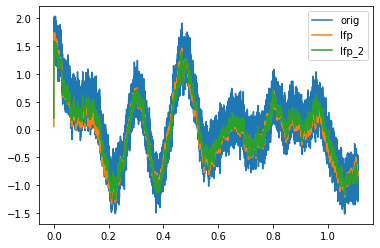

In [ ]:
plt.plot(sim_time[win], sim_signal[win], label='orig')
plt.plot(lfp_time[lfp_win], lfp_signal[lfp_win],label='lfp')
plt.plot(lfp_time[lfp_win], lfp_signal_2[lfp_win],label='lfp_2')

plt.legend(loc='best')

find the phase of the spikes on the new signal

In [ ]:
lfp_analytic_2 = signal.hilbert(lfp_signal_2)
lfp_phase_2 = np.angle(lfp_analytic_2)

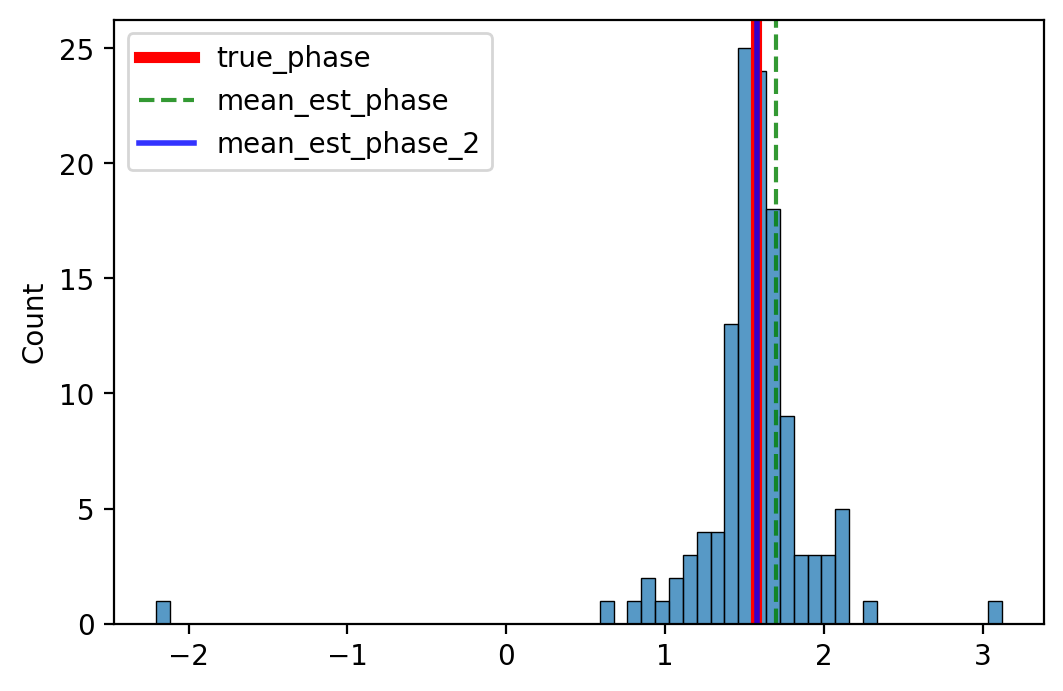

In [ ]:
lfp_spk_phases_2 = lfp_phase_2[lfp_spk_locs]
m_lfp_spk_phase_2 = stats.circmean(lfp_spk_phases_2)
f,ax=plt.subplots(dpi=200)
ax = sns.histplot(lfp_spk_phases_2,ax=ax)
ax.axvline(sim_phase, color='r',label='true_phase', alpha=1,lw=4)
ax.axvline(m_lfp_spk_phase, color='g',ls='--', label='mean_est_phase',alpha=0.8)
ax.axvline(m_lfp_spk_phase_2, color='b',label='mean_est_phase_2', alpha=0.8, lw=2)

ax.legend(loc='best')

In [ ]:
phase_error_rad_2 = m_lfp_spk_phase_2-sim_phase
phase_error_deg_2 = np.rad2deg(phase_error_rad_2)
print(f"The corrected signal had a mean phase error of {phase_error_deg_2:0.2f} degrees.")

The corrected signal had a mean phase error of 0.48 degrees.


# Success!!!!!